In [1]:
import json
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:


def json_lines_to_pandas(file_path):
  """
  Reads a JSON Lines file with nested lists of dictionaries and converts it into a pandas DataFrame.

  Args:
    file_path: Path to the JSON Lines file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from the JSON Lines file.
  """

  data = []
  with open(file_path, 'r') as f:
    for line in f:
      try:
        line_data = json.loads(line)
        data.extend(line_data)  # Extend the list with the current line's data
      except json.JSONDecodeError:
        print(f"Error decoding line: {line}")
        continue

  df = pd.DataFrame(data)
  return df



In [ ]:
base_state="west_bengal"
target_state="punjab"
data=f"train_{base_state}_val_{target_state}"
print(data)
json_file_path = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/runs/obb/{data}_obb_v1_best.pt_640_128_300_0.25_0.50/predictions.json"
df = json_lines_to_pandas(json_file_path)
display(df.head(3))
print(df.shape)
len(df)

train_west_bengal_val_punjab


,image_id,category_id,score,rbox,poly
0,8429172_3610882,2,0.84681,"[462.969, 222.128, 13.303, 29.272, 0.001]","[469.608, 236.77, 469.633, 207.497, 456.33, 20..."
1,8429172_3610882,2,0.76496,"[164.363, 89.95, 23.601, 11.918, 0.079]","[175.654, 96.825, 176.598, 84.944, 153.072, 83..."
2,8429172_3602627,2,0.89196,"[200.127, 387.198, 11.963, 23.152, 0.579]","[198.803, 400.161, 211.466, 380.779, 201.452, ..."


(1208, 5)


1208

In [146]:
#count the number of unique values in the category_id column
print(df['category_id'].nunique())
print(df['category_id'].unique())
print(df.columns)
print(df['category_id'].value_counts().to_markdown())



2
[2 1]
Index(['image_id', 'category_id', 'score', 'rbox', 'poly'], dtype='object')
|   category_id |   count |
|--------------:|--------:|
|             2 |     936 |
|             1 |     272 |


In [147]:
df_val=df[['image_id','category_id']]
display(df_val.head(3))

,image_id,category_id
0,8429172_3610882,2
1,8429172_3610882,2
2,8429172_3602627,2


In [148]:
def create_dataframe_from_labels(labels_dir):
  """
  Creates a pandas DataFrame from label files in the given directory.

  Args:
    labels_dir: Path to the directory containing the label files.

  Returns:
    pandas.DataFrame: A DataFrame with 'image_id' (filename) and 'category_id' columns.
  """

  data = []
  for filename in os.listdir(labels_dir):
    if filename.endswith(".txt"):
      filepath = os.path.join(labels_dir, filename)
      with open(filepath, "r") as f:
        first_line = f.readline().strip()
        category_id = first_line.split(" ")[0]
        image_id = os.path.splitext(filename)[0] # Remove the file extension
        data.append({"image_id": image_id, "category_id": category_id})

  df = pd.DataFrame(data)
  return df

In [149]:
ground_truth_file_path =f"/home/patel_zeel/kiln_compass_24/data/{target_state}/labels"
print(ground_truth_file_path)
df_gt = create_dataframe_from_labels(ground_truth_file_path)
display(df_gt.head(3))
print(df_gt['category_id'].unique())

/home/patel_zeel/kiln_compass_24/data/punjab/labels


,image_id,category_id
0,8357627_3742966,2
1,8396151_3495310,2
2,8343868_3522827,2


['2' '1']


In [150]:
merged_df = pd.merge(df_val, df_gt, on='image_id', suffixes=('_val', '_gt'))
display(merged_df.head(3))
#make the category_id_gt column as integer
merged_df['category_id_gt'] = merged_df['category_id_gt'].astype(int)
merged_df['correct'] = merged_df['category_id_val'] == merged_df['category_id_gt']
display(merged_df.head(3))
#display the rows whre the correct column is False
display(merged_df[merged_df['correct'] == False].head(2))
print(merged_df['correct'].value_counts())
#

,image_id,category_id_val,category_id_gt
0,8429172_3610882,2,2
1,8429172_3610882,2,2
2,8429172_3602627,2,2


,image_id,category_id_val,category_id_gt,correct
0,8429172_3610882,2,2,True
1,8429172_3610882,2,2,True
2,8429172_3602627,2,2,True


,image_id,category_id_val,category_id_gt,correct
4,8429172_3572358,1,2,False
6,8429172_3569606,1,2,False


correct
True     772
False    285
Name: count, dtype: int64


In [151]:
#make a confusion matrix where rows are pred_0,pred_1,pred_2 and column are gt_0,gt_1,gt_2
# cm=confusion_matrix(merged_df['category_id_gt'], merged_df['category_id_val'])
cm = confusion_matrix(merged_df['category_id_gt'], merged_df['category_id_val'], labels=[0, 1, 2])
if 0 not in merged_df['category_id_gt'].unique():
    cm[0, :] = 0  # Set row for class 0 to zero
    cm[:, 0] = 0  # Set column for class 0 to zero

# display(cm)
tp = np.diag(cm)  # True Positives for each class
fp = cm.sum(axis=0) - tp  # False Positives for each class
fn = cm.sum(axis=1) - tp  # False Negatives for each class
tn = cm.sum() - (tp + fp + fn)  # True Negatives for each class


# Metrics
with np.errstate(divide='ignore', invalid='ignore'):
    precision = np.nan_to_num(tp / (tp + fp), nan=0.0)  # Handle division by zero
    recall = np.nan_to_num(tp / (tp + fn), nan=0.0)  
    f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)  

confusion_matrix_df = pd.DataFrame(cm, columns=["GT_0", "GT_1", "GT_2"], index=["Pred_0", "Pred_1", "Pred_2"])

# Create DataFrame for metrics
metrics_df = pd.DataFrame({
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score,
    "TP": tp,
    "FP": fp,
    "FN": fn,
    "TN": tn
}, index=["CFCBK", "FCBK", "Zigzag"])



# print(f"\nClass-wise Metrics: base={base_state}, target={target_state}")
# display(metrics_df.style.format("{:.2f}").background_gradient(cmap="Greens", subset=["Precision", "Recall", "F1 Score"]))
 # Calculate the mean of each metric
mean_precision = precision.mean()
mean_recall = recall.mean()
mean_f1_score = f1_score.mean()
mean_tp = tp.mean() if not np.isnan(tp.mean()) else '-'
mean_fp = fp.mean() if not np.isnan(fp.mean()) else '-'
mean_fn = fn.mean() if not np.isnan(fn.mean()) else '-'
mean_tn = tn.mean() if not np.isnan(tn.mean()) else '-'

# Add mean values to the DataFrame
metrics_df.loc["Mean"] = [mean_precision, mean_recall, mean_f1_score, mean_tp, mean_fp, mean_fn, mean_tn]


# Display DataFrames
print(f"Confusion Matrix: train_{base_state}_val_{target_state}")
display(confusion_matrix_df.style.background_gradient(cmap="Blues"))

# Display the DataFrame
print(f"Class-wise Metrics with Mean: base={base_state}, target={target_state}")
display(metrics_df.style.format("{:.2f}").background_gradient(cmap="Greens"))


Confusion Matrix: train_west_bengal_val_punjab


,GT_0,GT_1,GT_2
Pred_0,0,0,0
Pred_1,0,34,86
Pred_2,0,199,738


Class-wise Metrics with Mean: base=west_bengal, target=punjab


,Precision,Recall,F1 Score,TP,FP,FN,TN
CFCBK,0.00,0.00,0.00,0.00,0.00,0.00,1057.00
FCBK,0.15,0.28,0.19,34.00,199.00,86.00,738.00
Zigzag,0.90,0.79,0.84,738.00,86.00,199.00,34.00
Mean,0.35,0.36,0.34,257.33,95.00,95.00,609.67


In [152]:
metrics_df["Target State"] = target_state 
csv_file = f"{base_state}_to_different_state_metrics_result.csv"

# Append the result to the CSV file
if not os.path.isfile(csv_file):
    # If the file doesn't exist, create it with headers
    metrics_df.to_csv(csv_file, mode='w', header=True)
else:
    # If the file exists, append without header
    metrics_df.to_csv(csv_file, mode='a', header=False)

In [176]:
base_state="punjab"
csv_file = f"{base_state}_to_different_state_metrics_result.csv"

result_dir="/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/result_csv/"
csv_file = os.path.join(result_dir, csv_file)
state_metrics_df = pd.read_csv(csv_file, index_col=0)
display(state_metrics_df)


,Precision,Recall,F1 Score,TP,FP,FN,TN,Target State
CFCBK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,462.000000,west_bengal
FCBK,0.636364,0.043478,0.081395,7.000000,4.000000,154.000000,297.000000,west_bengal
Zigzag,0.658537,0.986711,0.789894,297.000000,154.000000,4.000000,7.000000,west_bengal
Mean,0.431633,0.343396,0.290430,101.333333,52.666667,52.666667,255.333333,west_bengal
CFCBK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1499.000000,haryana
FCBK,0.075472,0.068966,0.072072,4.000000,49.000000,54.000000,1392.000000,haryana
Zigzag,0.962656,0.965996,0.964323,1392.000000,54.000000,49.000000,4.000000,haryana
Mean,0.346042,0.344987,0.345465,465.333333,34.333333,34.333333,965.000000,haryana
CFCBK,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,2155.000000,uttar_pradesh
FCBK,0.595016,0.179511,0.275812,191.000000,130.000000,873.000000,1007.000000,uttar_pradesh


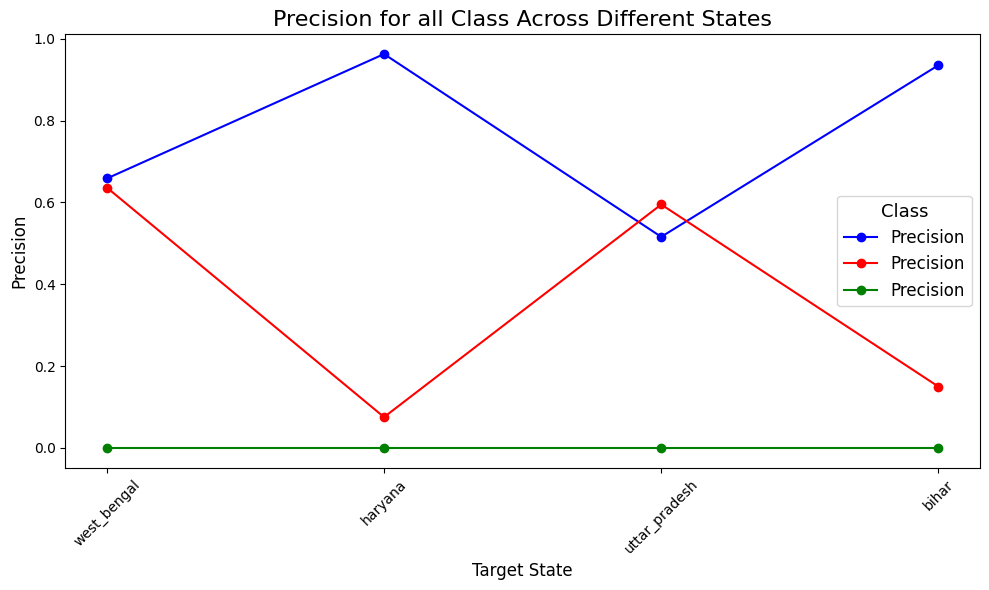

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming state_metrics_df is already loaded and contains the necessary columns
# Filter the DataFrame for only the "Zigzag" class
zigzag_precision_df = state_metrics_df[state_metrics_df.index == 'Zigzag']
fcbk_precision_df = state_metrics_df[state_metrics_df.index == 'FCBK']
cfcbk_precision_df = state_metrics_df[state_metrics_df.index == 'CFCBK']    

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a color palette
sns.set_palette("Set2")

# Plot Precision values for Zigzag class across different states
plt.plot(zigzag_precision_df['Target State'], zigzag_precision_df['Precision'], marker='o', color='b', label='Precision')
plt.plot(fcbk_precision_df['Target State'], fcbk_precision_df['Precision'], marker='o', color='r', label='Precision')
plt.plot(cfcbk_precision_df['Target State'], cfcbk_precision_df['Precision'], marker='o', color='g', label='Precision')
# Set the title and labels
plt.title('Precision for all Class Across Different States', fontsize=16)
plt.xlabel('Target State', fontsize=12)
plt.ylabel('Precision', fontsize=12)


# Add a legend
plt.legend(title='Class', fontsize=12, title_fontsize='13')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


In [178]:
print(state_metrics_df.columns)



Index(['Precision', 'Recall', 'F1 Score', 'TP', 'FP', 'FN', 'TN',
       'Target State'],
      dtype='object')


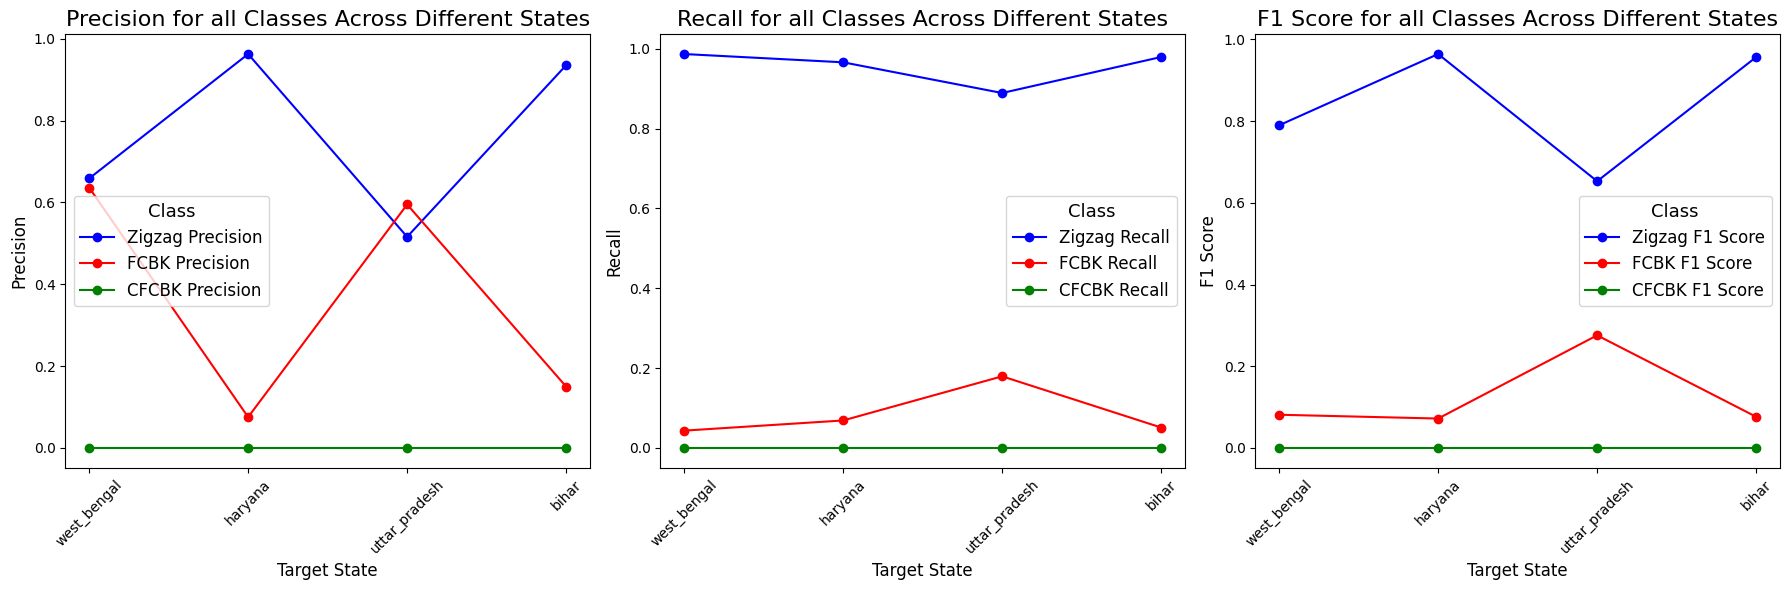

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming state_metrics_df is already loaded and contains the necessary columns
# Filter the DataFrame for each class (Zigzag, FCBK, CFCBK)
zigzag_df = state_metrics_df[state_metrics_df.index == 'Zigzag']
fcbk_df = state_metrics_df[state_metrics_df.index == 'FCBK']
cfcbk_df = state_metrics_df[state_metrics_df.index == 'CFCBK']

# Set the figure size and create subplots (3 rows, 1 column)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create a color palette
sns.set_palette("Set2")

# --- Precision Plot ---
axes[0].plot(zigzag_df['Target State'], zigzag_df['Precision'], marker='o', color='b', label='Zigzag Precision')
axes[0].plot(fcbk_df['Target State'], fcbk_df['Precision'], marker='o', color='r', label='FCBK Precision')
axes[0].plot(cfcbk_df['Target State'], cfcbk_df['Precision'], marker='o', color='g', label='CFCBK Precision')

axes[0].set_title('Precision for all Classes Across Different States', fontsize=16)
axes[0].set_xlabel('Target State', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].legend(title='Class', fontsize=12, title_fontsize='13')
axes[0].tick_params(axis='x', rotation=45)

# --- Recall Plot ---
axes[1].plot(zigzag_df['Target State'], zigzag_df['Recall'], marker='o', color='b', label='Zigzag Recall')
axes[1].plot(fcbk_df['Target State'], fcbk_df['Recall'], marker='o', color='r', label='FCBK Recall')
axes[1].plot(cfcbk_df['Target State'], cfcbk_df['Recall'], marker='o', color='g', label='CFCBK Recall')

axes[1].set_title('Recall for all Classes Across Different States', fontsize=16)
axes[1].set_xlabel('Target State', fontsize=12)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].legend(title='Class', fontsize=12, title_fontsize='13')
axes[1].tick_params(axis='x', rotation=45)

# --- F1 Score Plot ---
axes[2].plot(zigzag_df['Target State'], zigzag_df['F1 Score'], marker='o', color='b', label='Zigzag F1 Score')
axes[2].plot(fcbk_df['Target State'], fcbk_df['F1 Score'], marker='o', color='r', label='FCBK F1 Score')
axes[2].plot(cfcbk_df['Target State'], cfcbk_df['F1 Score'], marker='o', color='g', label='CFCBK F1 Score')

axes[2].set_title('F1 Score for all Classes Across Different States', fontsize=16)
axes[2].set_xlabel('Target State', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].legend(title='Class', fontsize=12, title_fontsize='13')
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
